
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.18.1?urlpath=lab/tree/cta_data_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[cta_data_analysis.ipynb](../_static/notebooks/cta_data_analysis.ipynb) |
[cta_data_analysis.py](../_static/notebooks/cta_data_analysis.py)
</div>


# CTA data analysis with Gammapy

## Introduction

**This notebook shows an example how to make a sky image and spectrum for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic center. This is a tiny (and thus quick to process and play with and learn) subset of the simulated CTA dataset that was produced for the first data challenge in August 2017.


## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!gammapy info --no-envvar --no-system


Gammapy package:

	version                : 0.18.1     
	path                   : /Users/adonath/github/adonath/gammapy/gammapy 


Other packages:

	numpy                  : 1.18.5     
	scipy                  : 1.5.0      
	astropy                : 4.0.1.post1 
	regions                : 0.4        
	click                  : 7.1.2      
	yaml                   : 5.3.1      
	IPython                : 7.16.1     
	jupyterlab             : 2.1.5      
	matplotlib             : 3.2.2      
	pandas                 : 1.0.5      
	healpy                 : 1.13.0     
	iminuit                : 1.4.5      
	sherpa                 : 4.12.0     
	naima                  : 0.9.1      
	emcee                  : 2.2.1      
	corner                 : 2.1.0      
	parfive                : 1.1.0      



In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    GaussianSpatialModel,
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [4]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)

## Select observations

A Gammapy analysis usually starts by creating a `~gammapy.data.DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three observations near the galactic center.

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

In [6]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [7]:
obs_id = [110380, 111140, 111159]
observations = data_store.get_observations(obs_id)

In [8]:
obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
data_store.obs_table.select_obs_id(obs_id)[obs_cols]

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
,deg,deg,s
int64,float64,float64,float64
110380,359.9999912037958,-1.299995937905366,1764.0
111140,358.4999833830074,1.3000020211954284,1764.0
111159,1.5000056568267741,1.299940468335294,1764.0


## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral analysis

In [9]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), npix=(500, 400), binsz=0.02, frame="galactic", axes=[axis]
)
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 400, 9)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg

### Compute images

Exclusion mask currently unused. Remove here or move to later in the tutorial?

In [10]:
target_position = SkyCoord(0, 0, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

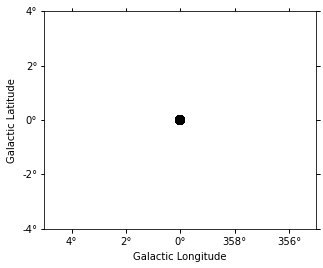

In [11]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();

In [12]:
%%time
stacked = MapDataset.create(geom=geom)
stacked.edisp = None
maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.5 * u.deg)

for obs in observations:
    cutout = stacked.cutout(obs.pointing_radec, width="5 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)

CPU times: user 3.25 s, sys: 404 ms, total: 3.66 s
Wall time: 3.61 s


In [13]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
dataset_image = stacked.to_image()

### Show images

Let's have a quick look at the images we computed ...

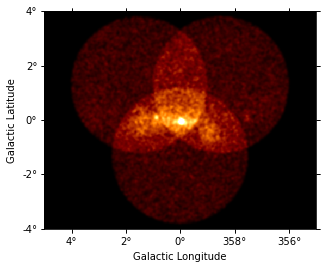

In [14]:
dataset_image.counts.smooth(2).plot(vmax=5);

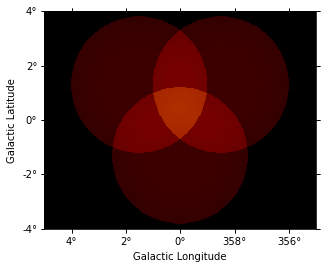

In [15]:
dataset_image.background.plot(vmax=5);

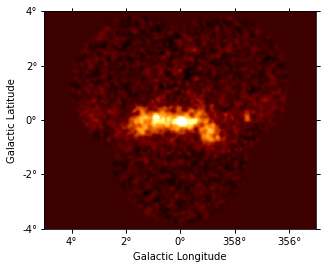

In [16]:
dataset_image.excess.smooth(3).plot(vmax=2);

## Source Detection

Use the class `~gammapy.estimators.TSMapEstimator` and function `gammapy.estimators.utils.find_peaks` to detect sources on the images. We search for 0.1 deg sigma gaussian sources in the dataset.

In [17]:
spatial_model = GaussianSpatialModel(sigma="0.05 deg")
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [18]:
ts_image_estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",
    selection_optional=[],
    downsampling_factor=2,
    sum_over_energy_groups=False,
    energy_edges=[0.1, 10] * u.TeV,
)

In [19]:
%%time
images_ts = ts_image_estimator.run(stacked)

/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 8.39 s, sys: 188 ms, total: 8.58 s
Wall time: 8.91 s


In [20]:
sources = find_peaks(
    images_ts["sqrt_ts"].get_image_by_idx((0,)),
    threshold=5,
    min_distance="0.2 deg",
)
sources

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
43.596,252,197,266.42400,-29.00490
22.196,207,202,266.85900,-28.18386
15.67,185,202,267.11657,-27.80719
12.784,373,205,264.79470,-30.97749
12.346,306,183,266.05018,-30.07215
7.3171,90,209,268.07455,-26.10409
6.1645,405,236,263.78276,-31.18457
5.2403,190,30,270.44708,-29.62765


In [21]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.42399798, -29.00490483), (266.85900392, -28.18385658),
     (267.11657041, -27.80719081), (264.79469899, -30.97749371),
     (266.05017781, -30.07215113), (268.07454639, -26.10409446),
     (263.78276218, -31.18456687), (270.44708387, -29.62765242)]>

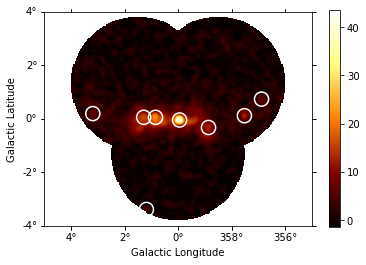

In [22]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

## Spatial analysis

See other notebooks for how to run a 3D cube or 2D image based analysis.

## Spectrum

We'll run a spectral analysis using the classical reflected regions background estimation method,
and using the on-off (often called WSTAT) likelihood function.

In [23]:
e_reco = MapAxis.from_energy_bounds(0.1, 40, 40, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(
    0.05, 100, 200, unit="TeV", name="energy_true"
)

dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

In [24]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [25]:
%%time
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=f"obs-{observation.obs_id}"), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 4.21 s, sys: 229 ms, total: 4.43 s
Wall time: 5.09 s


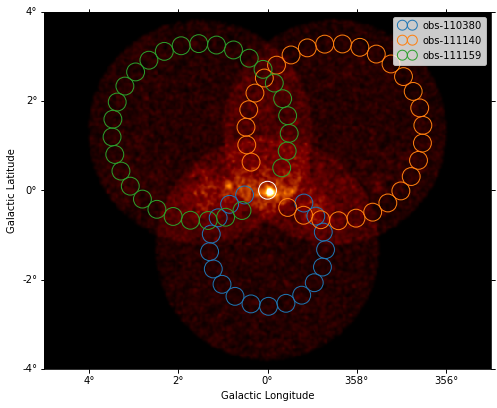

In [26]:
plt.figure(figsize=(8, 8))
_, ax, _ = dataset_image.counts.smooth("0.03 deg").plot(vmax=8)

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="white")
plot_spectrum_datasets_off_regions(datasets, ax=ax)

### Model fit

The next step is to fit a spectral model, using all data (i.e. a "global" fit, using all energies).

In [27]:
%%time
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

model = SkyModel(spectral_model=spectral_model, name="source-gc")

datasets.models = model

fit = Fit(datasets)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 104
	total stat : 88.36

CPU times: user 1.18 s, sys: 20.2 ms, total: 1.2 s
Wall time: 1.29 s


### Spectral points

Finally, let's compute spectral points. The method used is to first choose an energy binning, and then to do a 1-dim likelihood fit / profile to compute the flux and flux error.

In [28]:
# Flux points are computed on stacked observation
stacked_dataset = datasets.stack_reduce(name="stacked")

print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 413 
  Total off counts                : 2095.00
  Total background counts         : 85.43
  Total excess counts             : 327.57

  Predicted counts                : 438.83
  Predicted background counts     : 85.25
  Predicted excess counts         : 353.58

  Exposure min                    : 9.94e+07 m2 s
  Exposure max                    : 2.46e+10 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 989.704

  Number of total bins            : 40 
  Number of fit bins              : 30 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 48.41

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source-gc
    Datasets names            : None
    Spectral model type       : Pow

In [29]:
energy_edges = MapAxis.from_energy_bounds("1 TeV", "30 TeV", nbin=5).edges

stacked_dataset.models = model

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="source-gc")
flux_points = fpe.run(datasets=[stacked_dataset])
flux_points.table_formatted

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
106,1.375,0.946,2.000,1.526e-12,1.645e-12,2.170e-12,2.886e-12,0.948,13.412,True,0.117,152.513,0.121,0.113,1.197,0.200 .. 5.000,86.166 .. 416.726,12.350,1.447e-12,1.827e-12,1.783e-13,1.841e-13,1.727e-13
73,2.699,2.000,3.641,3.021e-13,5.029e-13,1.321e-12,2.200e-12,1.179,2.245,True,0.160,150.654,0.166,0.154,1.525,0.200 .. 5.000,79.568 .. 216.102,12.274,3.563e-13,4.606e-13,4.835e-14,5.024e-14,4.650e-14
54,5.295,3.641,7.700,5.980e-14,2.482e-13,1.260e-12,1.677e-12,1.226,0.624,True,0.190,121.570,0.199,0.182,1.642,0.200 .. 5.000,62.910 .. 151.209,11.026,7.332e-14,9.817e-14,1.138e-14,1.190e-14,1.087e-14
13,11.198,7.700,16.284,9.888e-15,8.679e-14,9.321e-13,1.240e-12,0.643,5.744,True,0.218,21.789,0.238,0.198,1.162,0.200 .. 5.000,12.582 .. 101.386,4.668,6.353e-15,1.149e-14,2.154e-15,2.356e-15,1.961e-15
4,21.971,16.284,29.645,1.957e-15,2.653e-14,5.675e-13,9.449e-13,0.567,2.899,True,0.354,6.250,0.416,0.298,1.529,0.200 .. 5.000,4.583 .. 37.084,2.500,1.109e-15,2.992e-15,6.938e-16,8.137e-16,5.833e-16


### Plot

Let's plot the spectral model and points. You could do it directly, but for convenience we bundle the model and the flux points in a `FluxPointDataset`:

In [30]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model)

(array([0.42957043, 0.6985657 , 1.65385672, 3.49748113, 5.6875896 ]), array([0.62468796, 0.94256271, 2.40506396, 5.08609104, 7.6741671 ]))


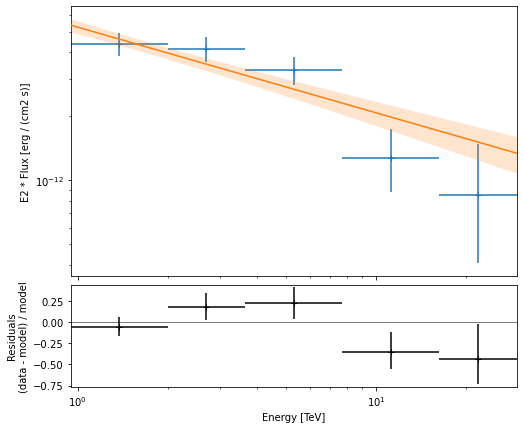

In [31]:
flux_points_dataset.plot_fit();

## Exercises

* Re-run the analysis above, varying some analysis parameters, e.g.
    * Select a few other observations
    * Change the energy band for the map
    * Change the spectral model for the fit
    * Change the energy binning for the spectral points
* Change the target. Make a sky image and spectrum for your favourite source.
    * If you don't know any, the Crab nebula is the "hello world!" analysis of gamma-ray astronomy.

In [32]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

* This notebook showed an example of a first CTA analysis with Gammapy, using simulated 1DC data.
* Let us know if you have any question or issues!